## B01 - Use SatCLIP embeddings to predict air temperatures

For better performance, we generally recommend using a GPU runtime. In Colab, go to `Runtime -> Change runtime type` and select `T4 GPU`. For this example, a GPU is not necessary as our dataset is quite small.

### Setup

We start by setting up **SatCLIP** code and installing dependencies.

In [1]:
!rm -r sample_data .config # Empty current directory
!git clone https://github.com/microsoft/satclip.git . # Clone SatCLIP repository

Cloning into '.'...
remote: Enumerating objects: 158, done.
remote: Counting objects: 100% (63/63), done.
remote: Compressing objects: 100% (57/57), done.
remote: Total 158 (delta 29), reused 23 (delta 6), pack-reused 95
Receiving objects: 100% (158/158), 9.27 MiB | 12.65 MiB/s, done.
Resolving deltas: 100% (63/63), done.


In [2]:
!pip install lightning --quiet
!pip install rasterio --quiet
!pip install torchgeo --quiet
!pip install basemap --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 12.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 840.2/840.2 kB 18.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 777.7/777.7 kB 13.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.6/20.6 MB 25.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 378.5/378.5 kB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 756.0/756.0 kB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 684.1/684.1 kB 11.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 535.2/535.2 kB 11.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 16.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 14.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━

Chose a SatCLIP model from the list of available pretrained models [here](https://github.com/microsoft/satclip#pretrained-models). They all perform somewhat similarly. Let's download a SatCLIP using a ViT16 vision encoder and $L=10$ Legendre polynomials in the location encoder (i.e., a low-resolution SatCLIP).

In [3]:
!wget 'https://satclip.z13.web.core.windows.net/satclip/satclip-vit16-l10.ckpt'

--2024-01-21 00:52:20--  https://satclip.z13.web.core.windows.net/satclip/satclip-vit16-l10.ckpt
Resolving satclip.z13.web.core.windows.net (satclip.z13.web.core.windows.net)... 52.239.221.231
Connecting to satclip.z13.web.core.windows.net (satclip.z13.web.core.windows.net)|52.239.221.231|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 102550795 (98M) [application/zip]
Saving to: ‘satclip-vit16-l10.ckpt’

satclip-vit16-l10.c 100%[===================>]  97.80M  13.1MB/s    in 12s     

2024-01-21 00:52:33 (8.35 MB/s) - ‘satclip-vit16-l10.ckpt’ saved [102550795/102550795]



Load required packages.

In [4]:
import sys
sys.path.append('./satclip')

import torch
from load import get_satclip

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') # Automatically select device

## Get air temperature dataset

In this example, we work with a dataset of annual mean temperature values recorded at ~3000 locations around the planet introduced [here](https://www.nature.com/articles/sdata2018246). To download the dataset, we can use code from the [PE-GNN repository](https://github.com/konstantinklemmer/pe-gnn/).

In [5]:
from urllib import request
import numpy as np
import pandas as pd
import io
import torch


def get_air_temp_data(pred="temp",norm_y=True,norm_x=True):
  '''
  Download and process the Global Air Temperature dataset (more info: https://www.nature.com/articles/sdata2018246)

  Parameters:
  pred = numeric; outcome variable to be returned; choose from ["temp", "prec"]
  norm_y = logical; should outcome be normalized
  norm_min_val = integer; choice of [0,1], setting whether normalization in range[0,1] or [-1,1]

  Return:
  coords = spatial coordinates (lon/lat)
  x = features at location
  y = outcome variable
  '''
  url = 'https://springernature.figshare.com/ndownloader/files/12609182'
  url_open = request.urlopen(url)
  inc = np.array(pd.read_csv(io.StringIO(url_open.read().decode('utf-8'))))
  coords = inc[:,:2]
  if pred=="temp":
    y = inc[:,4].reshape(-1)
    x = inc[:,5]
  else:
    y = inc[:,5].reshape(-1)
    x = inc[:,4]
  if norm_y==True:
    y = y / y.max()
  if norm_x==True:
    x = x / x.max()

  return torch.tensor(coords), torch.tensor(x), torch.tensor(y)

In [6]:
coords, _, y = get_air_temp_data()

Let's plot our data. Here we show a map of the world with our locations colored by mean temperatures.

Text(0.5, 1.0, 'Annual Mean Temperatures')

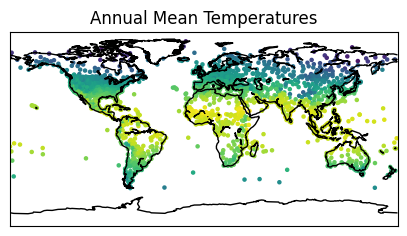

In [7]:
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap

fig, ax = plt.subplots(1, figsize=(5, 3))

m = Basemap(projection='cyl', resolution='c', ax=ax)
m.drawcoastlines()
ax.scatter(coords[:,0], coords[:,1], c=y, s=5)
ax.set_title('Annual Mean Temperatures')

## Predictive modeling

We now want to predict annual mean temperature values using SatCLIP embeddings. First, we need to obtain the location embeddings for our dataset from the pretrained model.

In [ ]:
satclip_path = 'satclip-vit16-l10.ckpt'

model = get_satclip(satclip_path, device=device) # Only loads location encoder by default
model.eval()
with torch.no_grad():
  x  = model(coords.double().to(device)).detach().cpu()

We have now collected a 256-dimensional location embedding for each latitude/longitude coordinate in our dataset.

In [ ]:
print(coords.shape)
print(x.shape)

torch.Size([3076, 2])
torch.Size([3076, 256])


Next, let's split our dataset into 50% training and 50% testing data.

In [ ]:
from torch.utils.data import TensorDataset, random_split

dataset = TensorDataset(coords, x, y)

train_size = int(0.5 * len(dataset))
test_size = len(dataset) - train_size
train_set, test_set = random_split(dataset, [train_size, test_size])

coords_train, x_train, y_train = train_set.dataset.tensors[0][train_set.indices], train_set.dataset.tensors[1][train_set.indices], train_set.dataset.tensors[2][train_set.indices]
coords_test, x_test, y_test = test_set.dataset.tensors[0][test_set.indices], test_set.dataset.tensors[1][test_set.indices], test_set.dataset.tensors[2][test_set.indices]

Text(0.5, 1.0, 'Train-Test Split')

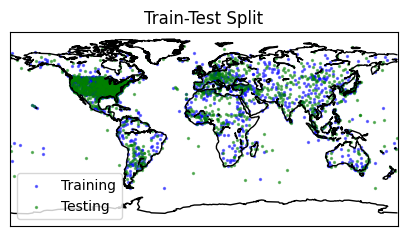

In [ ]:
fig, ax = plt.subplots(1, figsize=(5, 3))

m = Basemap(projection='cyl', resolution='c', ax=ax)
m.drawcoastlines()
ax.scatter(coords_train[:,0], coords_train[:,1], c='blue', s=2, label='Training',alpha=0.5)
ax.scatter(coords_test[:,0], coords_test[:,1], c='green', s=2, label='Testing',alpha=0.5)
ax.legend()
ax.set_title('Train-Test Split')

Next we define our prediction model, a simple MLP. (NOTE: SatCLIP embeddings can of course be used with any predictive model, we just opt for an MLP here for simplicity. You can also directly unfreeze the location encoder `model` above and fine-tune it.)

In [ ]:
import torch.nn as nn

class MLP(nn.Module):
    def __init__(self, input_dim, dim_hidden, num_layers, out_dims):
        super(MLP, self).__init__()

        layers = []
        layers += [nn.Linear(input_dim, dim_hidden, bias=True), nn.ReLU()] # Input layer
        layers += [nn.Linear(dim_hidden, dim_hidden, bias=True), nn.ReLU()] * num_layers # Hidden layers
        layers += [nn.Linear(dim_hidden, out_dims, bias=True)] # Output layer

        self.features = nn.Sequential(*layers)

    def forward(self, x):
        return self.features(x)

In [ ]:
model

LocationEncoder(
  (posenc): SphericalHarmonics()
  (nnet): SirenNet(
    (layers): ModuleList(
      (0-1): 2 x Siren(
        (activation): Sine()
      )
    )
    (last_layer): Siren(
      (activation): Identity()
    )
  )
)

Let's set up and run the training loop.

In [ ]:
pred_model = MLP(input_dim=256, dim_hidden=64, num_layers=2, out_dims=1).float().to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(pred_model.parameters(), lr=0.001)

losses = []
epochs = 3000

for epoch in range(epochs):
  optimizer.zero_grad()
  # Forward pass
  y_pred = pred_model(x_train.float().to(device))
  # Compute the loss
  loss = criterion(y_pred.reshape(-1), y_train.float().to(device))
  # Backward pass
  loss.backward()
  # Update the parameters
  optimizer.step()
  # Append the loss to the list
  losses.append(loss.item())
  if (epoch + 1) % 250 == 0:
    print(f"Epoch {epoch + 1}, Loss: {loss.item():.4f}")

Epoch 250, Loss: 0.0016
Epoch 500, Loss: 0.0010
Epoch 750, Loss: 0.0009
Epoch 1000, Loss: 0.0007
Epoch 1250, Loss: 0.0005
Epoch 1500, Loss: 0.0004
Epoch 1750, Loss: 0.0005
Epoch 2000, Loss: 0.0004
Epoch 2250, Loss: 0.0003
Epoch 2500, Loss: 0.0003
Epoch 2750, Loss: 0.0003
Epoch 3000, Loss: 0.0004


Let's make predictions on the test set!

In [ ]:
with torch.no_grad():
  model.eval()
  y_pred_test = pred_model(x_test.float().to(device))

# Print test loss
print(f'Test loss: {criterion(y_pred_test.reshape(-1), y_test.float().to(device)).item()}')

Test loss: 0.006281182635575533


Let's show the results on a map!

Text(0.5, 1.0, 'Predicted')

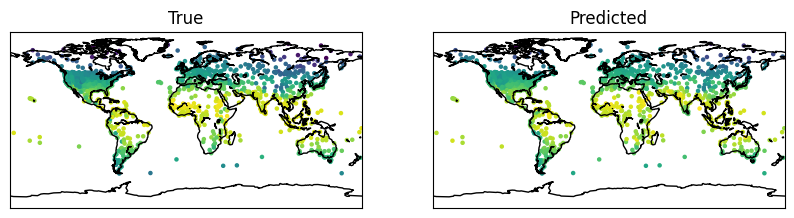

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(10, 3))

m = Basemap(projection='cyl', resolution='c', ax=ax[0])
m.drawcoastlines()
ax[0].scatter(coords_test[:,0], coords_test[:,1], c=y_test, s=5)
ax[0].set_title('True')

m = Basemap(projection='cyl', resolution='c', ax=ax[1])
m.drawcoastlines()
ax[1].scatter(coords_test[:,0], coords_test[:,1], c=y_pred_test.reshape(-1), s=5)
ax[1].set_title('Predicted')